## DecisionTreeRegressor

In [39]:
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import json  
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/traffic.csv',parse_dates = [7])

hol_dict = {'None' : 0, 'Columbus Day' : 1,'Veterans Day' : 1,'Thanksgiving Day' : 1,'Christmas Day' : 1,'New Years Day' : 1,
            'Washingtons Birthday' : 1,'Memorial Day' : 1,'Independence Day' : 1,'State Fair' : 1,'Labor Day' : 1,
            'Martin Luther King Jr Day' : 1} 

rain_dict = {'light rain' : 'avg_rain', 'proximity shower rain' : 'low_rain',
             'moderate rain' : 'avg_rain','heavy intensity rain' : 'avg_rain',
             'freezing rain' : 'low_rain','light intensity shower rain' : 'low_rain', 
             'very heavy rain' : 'heavy_rain'}
snow_dict = {
    'heavy snow' : 'low_snow', 'shower snow' : 'low_snow', 'light rain and snow': 'low_snow', 
    'light shower snow' : 'low_snow', 'sleet' : 'low_snow','snow' : 'high_snow', 'light snow' : 'high_snow'
}
cloud_dict = {
    'scattered clouds' : 'low_clouds', 'broken clouds' :'low_clouds',  
    'few clouds' :'low_clouds', 'overcast clouds' : 'high_clouds'
}

drizzle_dict = {
    'light intensity drizzle':'high_drizzle', 
    'shower drizzle' : 'low_drizzle',
    'drizzle':'low_drizzle','heavy intensity drizzle':'low_drizzle',
    
}

thund_dict = {'proximity thunderstorm' : 'proximity', 'proximity thunderstorm with rain' : 'proximity', 
              'proximity thunderstorm with drizzle' : 'proximity',
              'thunderstorm with light rain' : 'thunderstorm', 'thunderstorm with heavy rain' : 'thunderstorm',
              'thunderstorm with rain' : 'thunderstorm','thunderstorm' : 'thunderstorm', 
              'thunderstorm with light drizzle' : 'thunderstorm', 'thunderstorm with drizzle' : 'thunderstorm'
             }
other_dict = {'fog' : 'fog','haze' : 'haze',
             'mist' : 'mist', 'smoke' : 'smoke',
             'squalls' : 'smoke', 'sky is clear' : 'clear'}


hour_buckets = {0 : 'wee_hours',1 : 'wee_hours',2 : 'wee_hours',3 : 'wee_hours',4 : 'wee_hours',5 : 'wee_hours',
                6 : 'morning_hours',7 : 'morning_hours',8 : 'morning_hours',9 : 'morning_hours',
                10 : 'noon_hours',11 : 'noon_hours',12 : 'noon_hours',13 : 'noon_hours',14 : 'noon_hours',
                15 : 'evening_hours',16 : 'evening_hours',17 : 'evening_hours',
                18 : 'late_hours', 19 : 'late_hours', 20 : 'late_hours', 21 : 'late_hours',22 : 'late_hours', 23 : 'late_hours'}

month_buckets = {1 : 'season_0', 2 : 'season_0', 3 : 'season_1',
                 4 : 'season_1', 5 : 'season_2', 6 : 'season_2',
                 7 : 'season_1', 8 : 'season_2', 9 : 'season_1',
                 10 : 'season_2',11 : 'season_0',12 : 'season_0'}

final_dict = dict(**rain_dict, **snow_dict, **cloud_dict, **drizzle_dict, **thund_dict, **other_dict)

def write_files(final_dict, hour_buckets, month_buckets, hol_dict):
    '''
    Write the files into Disk.
    
    Input Parameters
        final_dict, hour_buckets, month_buckets, hol_dict : List of dictionaries to be stored onto disk
        
    Returns
        True : To verify if saving the files were successful
    '''
    with open('./Data/final_dict.json','w') as fp:
        json.dump(final_dict,fp,indent = 4)
    with open('./Data/hour_buckets.json','w') as fp:
        json.dump(hour_buckets,fp,indent = 4)
    with open('./Data/month_buckets.json','w') as fp:
        json.dump(month_buckets,fp,indent = 4)
    with open('./Data/hol_dict.json','w') as fp:
        json.dump(hol_dict,fp,indent = 4)
    
    return True
      
ok = write_files(final_dict, hour_buckets, month_buckets, hol_dict)
ok

True

In [3]:
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,New Years Day,263.49,0.0,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372
...,...,...,...,...,...,...,...,...,...
45640,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
45641,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
45642,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
45643,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [4]:
# Extract time based features from the dataframe
def extract_time_feat(df):
    '''
    Extract time based features from the datetime column.
    
    Input Parameters
        
        df : Input Dataframe
        
    Returns
        
        df : Dataframe with datetime features
    '''
    df['hour'] = df['date_time'].apply(lambda x:x.hour)
    df['day'] = df['date_time'].apply(lambda x:x.day)
    df['month'] = df['date_time'].apply(lambda x:x.month)
    df['year'] = df['date_time'].apply(lambda x:x.year)
    df['weekday'] = df['date_time'].apply(lambda x:x.weekday())
    
    # Creating boolean feature to verify if it is weekend
    df.loc[:,'weekend'] = df['weekday'].apply(lambda x: 1 if x == 5 or x == 6 else 0)
    df['weekend'] = df['weekend'].astype('category')
    
    return df[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'hour', 'day',
       'month', 'year','weekday','weekend','traffic_volume']]

def feat_cleaning_engg(df,final_dict,hour_buckets,month_buckets,hol_dict):
    '''
    Function to clean the data based on the Exploratory Data Analysis.
    
    Input Parameters
        
        df            : Input data frame that is passed to be cleaned.
        final_dict    : Dictionary related to weather_main and weather_description features needed for feature Engineering
        hour_buckets  : Dictionary related to date_time feature needed for feature engineering
        month_buckets : Dictionary related to date_time feature needed for feature engineering
        
    Output Parameters
    
        df : Cleaned and processed data frame
        
    '''
    df = extract_time_feat(df)
    
    # Imputing the anamoly of temp feature
    df['temp'] = df['temp'].replace(0.0, np.nan)
    df['temp'] = df['temp'].fillna(method = 'ffill')
    
    # Converting the temperature from Kelvin scale to Celsius scale
    df['temp'] = df['temp'] - 273.15
    
    df['holiday'] = df['holiday'].map(hol_dict)
    df['holiday'] = df['holiday'].astype('category')
    
    df['rain_1h'] = df['rain_1h'].replace(df['rain_1h'].max(),np.nan)
    df['rain_1h'] = df['rain_1h'].fillna(df[df['weather_description'] == 'very heavy rain']['rain_1h'].mean())
    
    df['weather_description'] = df['weather_description'].apply(lambda x : x.lower())
    df['weather_description'] = df['weather_description'].map(final_dict)
    
    df['time_slots'] = df['hour'].map(hour_buckets)
    df['time_slots'] = df['time_slots'].astype('category')
    
    df['season'] = df['month'].map(month_buckets)
    df['season'] = df['season'].astype('category')
    
    df = df[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 
       'weather_description', 'weekend', 'time_slots', 'season', 'traffic_volume']]
    df.to_csv('./Data/processed.csv',index = False)
    df['weather_description'] = df['weather_description'].astype('category')
    return df

df = feat_cleaning_engg(df,final_dict,hour_buckets,month_buckets,hol_dict)

In [5]:
def preprocessing_dtlr(df):
    '''
    Function for structuring the data suitable for the ML algorithms
    
    Input parameters :
        
        df : Input Dataframe
    
    Output parameters :
        
        df : Output dataframe
        
    '''
    numeric_feat = ['temp','rain_1h','snow_1h','clouds_all']    
    cat_feat = ['weather_description','time_slots','season']
    
    le = LabelEncoder()
    df = df.apply(LabelEncoder().fit_transform)
    joblib.dump(le, './Data/le.gz')
        
    return df

df = preprocessing_dtlr(df)
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_description,weekend,time_slots,season,traffic_volume
0,1,1277,0,0,22,8,0,4,0,1263
1,0,1306,0,0,16,8,0,4,0,1322
2,0,1344,0,0,30,11,0,4,0,766
3,0,1324,0,0,42,5,0,4,0,409
4,0,1293,0,0,42,5,0,4,0,205
...,...,...,...,...,...,...,...,...,...,...
45640,0,3410,0,0,30,8,1,1,1,3313
45641,0,3335,0,0,42,5,1,1,1,2554
45642,0,3330,0,0,42,13,1,1,1,1943
45643,0,3255,0,0,42,5,1,1,1,1273


In [6]:
model = DecisionTreeRegressor()
X,y = df.iloc[:,:-1],df.iloc[:,-1]
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.3,random_state = 2020)
model.fit(X_train,y_train)

print('R square score on train set and test set are :',model.score(X_train,y_train),model.score(X_val,y_val))
print('Root mean squared error :',np.sqrt(mean_squared_error(y_val,model.predict(X_val))))
print('Mean absolute error :',mean_absolute_error(y_val,model.predict(X_val)))

R square score on train set and test set are : 0.991952790499373 0.7122860209529152
Root mean squared error : 1042.4818723798967
Mean absolute error : 725.1631369980976


In [22]:

for dep in range(2,20):
    print('Depth is :',dep)
    model = DecisionTreeRegressor(max_depth = dep)
    X,y = df.iloc[:,:-1],df.iloc[:,-1]
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.3,random_state = 2020)
    model.fit(X_train,y_train)

    print('R square score on train set and test set are :',model.score(X_train,y_train),model.score(X_val,y_val))
    print('Root mean squared error :',np.sqrt(mean_squared_error(y_val,model.predict(X_val))))
    print('Mean absolute error :',mean_absolute_error(y_val,model.predict(X_val)))

Depth is : 2
R square score on train set and test set are : 0.5826887211369924 0.5710574998153342
Root mean squared error : 1272.8803131465254
Mean absolute error : 1020.1643370043286
Depth is : 3
R square score on train set and test set are : 0.7146306329638453 0.7109272469326386
Root mean squared error : 1044.940614252254
Mean absolute error : 752.8712274803955
Depth is : 4
R square score on train set and test set are : 0.790974999939677 0.782339924606492
Root mean squared error : 906.7288157610805
Mean absolute error : 671.8062397308895
Depth is : 5
R square score on train set and test set are : 0.8325356833998683 0.8199610349030637
Root mean squared error : 824.6530775673691
Mean absolute error : 594.9854218606769
Depth is : 6
R square score on train set and test set are : 0.8380686704923835 0.8249436830796666
Root mean squared error : 813.1617158943319
Mean absolute error : 587.3671017358583
Depth is : 7
R square score on train set and test set are : 0.8415079399999417 0.825647346

In [21]:
model = DecisionTreeRegressor(max_depth = 7)
X,y = df.iloc[:,:-1],df.iloc[:,-1]
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.3,random_state = 2020)
model.fit(X_train,y_train)

print('R square score on train set and test set are :',model.score(X_train,y_train),model.score(X_val,y_val))
print('Root mean squared error :',np.sqrt(mean_squared_error(y_val,model.predict(X_val))))
print('Mean absolute error :',mean_absolute_error(y_val,model.predict(X_val)))

R square score on train set and test set are : 0.8415079399999417 0.8256473461007622
Root mean squared error : 811.5257623929539
Mean absolute error : 585.8623567522077


In [28]:
fimp = pd.DataFrame(zip(X.columns,model.feature_importances_),columns = ['features','importance']).sort_values(by = 'importance')
g = sns.barplot(y = 'features', x = 'importance',data = fimp)

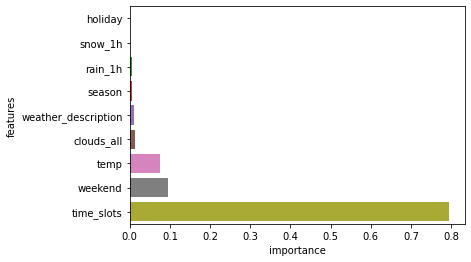

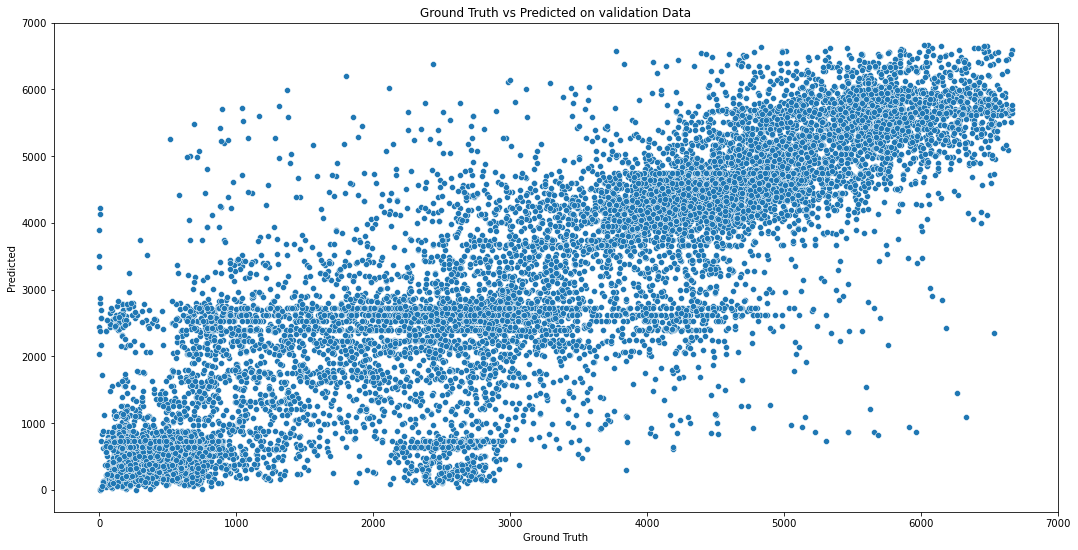

In [34]:
pred = model.predict(X_val)
diag = pd.DataFrame(zip(y_val,pred),columns = ['Ground Truth','Predicted'])

plt.figure(figsize = (18,9))
g = sns.scatterplot(x = 'Ground Truth', y = 'Predicted',data = diag)
plt.title('Ground Truth vs Predicted on validation Data')
plt.show()

## RandomForestRegressor

In [45]:
model = RandomForestRegressor(n_estimators = 200, max_depth = 6, random_state = 2020)
X,y = df.iloc[:,:-1],df.iloc[:,-1]
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.3,random_state = 2020)
model.fit(X_train,y_train)

print('R square score on train set and test set are :',model.score(X_train,y_train),model.score(X_val,y_val))
print('Root mean squared error :',np.sqrt(mean_squared_error(y_val,model.predict(X_val))))
print('Mean absolute error :',mean_absolute_error(y_val,model.predict(X_val)))

R square score on train set and test set are : 0.8392930529239874 0.8257609617304619
Root mean squared error : 811.2613068941798
Mean absolute error : 585.4278849318226


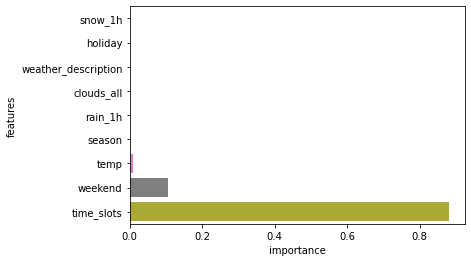

In [46]:
fimp = pd.DataFrame(zip(X.columns,model.feature_importances_),columns = ['features','importance']).sort_values(by = 'importance')
g = sns.barplot(y = 'features', x = 'importance',data = fimp)

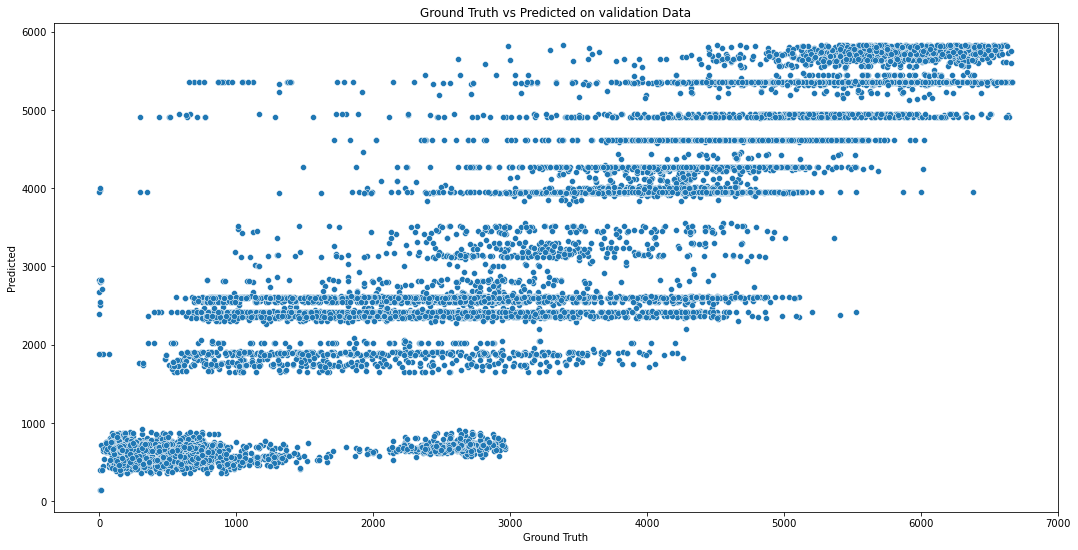

In [47]:
pred = model.predict(X_val)
diag = pd.DataFrame(zip(y_val,pred),columns = ['Ground Truth','Predicted'])

plt.figure(figsize = (18,9))
g = sns.scatterplot(x = 'Ground Truth', y = 'Predicted',data = diag)
plt.title('Ground Truth vs Predicted on validation Data')
plt.show()